# The game of SET

#### Riddler Classic for Friday March 22, 2020. Solution by [Laurent Lessard](https://laurentlessard.com)

This week's [Riddler Classic](https://fivethirtyeight.com/features/how-many-sets-of-cards-can-you-find/) is about the popular card game of SET. We will answer three questions:

- **Question 1:** What is the maximum number of cards you could have (from a single deck of 81 cards) such that there are no sets among them?

- **Question 2:** What is the largest number of sets one can possibly find among 12 cards? You are free to pick any board of 12 cards you like — your goal is to maximize the number of sets the board contains.

- **Question 3:** If you pick 12 cards at random (again, from a single deck of 81 cards), what’s the probability that they contain at least one set?

There are many excellent references on this game, and some very andvanced mathematics as well. This post will not delve into the mathematical structure of SET. Rather, my goal is to show how to solve these problems by using an integer programming model.

In [113]:
# NOTE: gurobipy requires a 64-bit distribution of Python

import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

In [55]:
# create an index of all the cards, represented as 4-arrays in {0,1,2}
cards = []
for color in range(3):
    for shape in range(3):
        for number in range(3):
            for shading in range(3):
                cards.append( np.array([color,shape,number,shading]) )
                
n = len(cards)

In [56]:
# create A matrix that is (# of sets) x (# number of cards)
# and tells you which sets contain which cards (binary matrix)

A = []
for i1 in range(n):
    c1 = cards[i1]
    for i2 in range(i1+1,n):
        c2 = cards[i2]
        for i3 in range(i2+1,n):
            c3 = cards[i3]
            q = sum( [ x % 3 for x in c1+c2+c3 ] )
            if q == 0:
                tmp = np.zeros(n)
                tmp[[i1,i2,i3]] = 1
                A.append(tmp)
m = len(A)
A = np.array(A)

In [252]:
# load images of cards!
S = plt.imread('set.png')
(sx,sy,sz) = S.shape
nx,ny = round(sx/9),round(sy/9)

shapes = ['_dia','_pil','_ess']
numbers = ['1','2','3']
colors = ['R','G','P']
patterns = ['_mpty','_htch','_fill']

# card list and associated images
SS = [[ S[i*nx:(i+1)*nx,j*ny:(j+1)*ny,:] for i in range(9)] for j in range(9) ]
imlist = [ SS[i][j] for i in range(9) for j in range(9) ]
cardlist = [ num+col+pat+sha for sha in shapes
                             for num in numbers
                             for col in colors
                             for pat in patterns ]

---

# Question 1

What is the maximum number of cards you could have (from a single deck of 81 cards) such that there are no sets among them?

#### Solution:
Suppose there are $n$ cards (81) and $m$ total possible sets (1080).
Let $A \in \{0,1\}^{m\times n}$ be a binary matrix such that $A_{ij}$ is 1 if set $i$ contains card $j$. We can compute this offline. Our variable is $z \in \{0,1\}^n$, which will determine which cards we select. The vector $Az$ tells us how many cards from each set are present. So if $Az \leq 2$ (componentwise), then we have no sets. Therefore, the problem we want to solve is:
$$\begin{aligned}
\underset{z\in\{0,1\}^n}{\text{maximize}} \qquad & \sum_{j=1}^n z_j \\
\text{such that} \qquad & \sum_{j=1}^n A_{ij} z_j \leq 2\quad\text{for }i=1,\dots,m
\end{aligned}$$
This problem has $n$ variables and $m$ constraints and can be solved in a couple seconds.

In [94]:
# define optimization model
m1 = gp.Model("m1")

# variable: which cards we select
z = m1.addVars(n, vtype=GRB.BINARY, name="z")

# constraint: no sets present
m1.addConstrs( (gp.quicksum( A[i,j]*z[j] for j in range(n) ) <= 2 for i in range(m)), "c0" )

# objective: maximize the number of selected cards
m1.setObjective( gp.quicksum(z[j] for j in range(n)), GRB.MAXIMIZE)

# optimize
m1.setParam('OutputFlag', 0)
m1.optimize()

# store and display result
print('Max number of cards with no set: %g' % m1.objVal)
zopt = [z[i].X for i in range(n)]

# print optimized set of cards (most cards with no set)
cardopt1 = [cards[i] for i in range(n) if zopt[i]==1]
cardopt1

Max number of cards with no set: 20


[array([0, 0, 0, 1]),
 array([0, 0, 2, 0]),
 array([0, 0, 2, 1]),
 array([0, 1, 1, 1]),
 array([0, 1, 2, 1]),
 array([0, 1, 2, 2]),
 array([1, 0, 0, 2]),
 array([1, 0, 2, 1]),
 array([1, 0, 2, 2]),
 array([1, 1, 1, 2]),
 array([1, 1, 2, 0]),
 array([1, 1, 2, 2]),
 array([2, 0, 0, 1]),
 array([2, 0, 0, 2]),
 array([2, 0, 1, 2]),
 array([2, 1, 0, 1]),
 array([2, 1, 1, 1]),
 array([2, 1, 1, 2]),
 array([2, 2, 0, 2]),
 array([2, 2, 1, 1])]

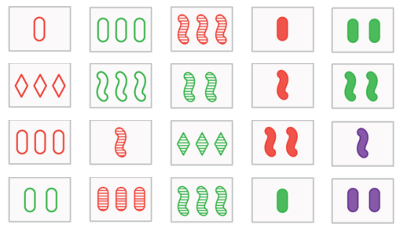

In [253]:
# PLOT SOLUTION: LARGEST SET OF CARDS WITH NO SET ("CAP SET")
fig, axs = plt.subplots(4,5, sharex=True, sharey=True, figsize=(7,4))
for i in range(4):
    for j in range(5):
        card = cardopt1[i+4*j]
        ix = card[0] + card[1]*3 + card[2]*9 + card[3]*27
        axs[i,j].imshow( imlist[ix] )
        axs[i,j].axis('off')

 ---
 
 # Question 2
 What is the largest number of sets one can possibly find among 12 cards? You are free to pick any board of 12 cards you like — your goal is to maximize the number of sets the board contains.

#### Solution:

Again, suppose there are $n$ cards (81) and $m$ total possible sets (1080). This time, we fix the number of cars to 12 and we want to maximize the number of sets present. Our variables will be $z \in \{0,1\}^n$, which will determine which cards we select, and $w \in \{0,1\}^m$, which will determine the sets we find. Again, the vector $Az$ tells us how many cards from each set are present. We must encode the constraint "If $w_i=1$ then $(Az)_i = 3$". We can encode this succinctly by writing $Az \ge 3w$ (componentwise). Therefore, the problem we want to solve is:
$$\begin{aligned}
\underset{z\in\{0,1\}^n,\,w\in\{0,1\}^m}{\text{maximize}} \qquad & \sum_{i=1}^m w_i \\
\text{such that} \qquad & \sum_{j=1}^n A_{ij} z_j \geq 3 w_i \quad\text{for }i=1,\dots,m\\
& \sum_{j=1}^n z_j = 12
\end{aligned}$$
This problem is a bit more complicated and takes a bit longer to solve than the first one because it has $n+m$ variables and $m+1$ constraints.

In [100]:
# define optimization model
m2 = gp.Model("m2")

# variable: which cards we select and which sets we can produce
z = m2.addVars(n, vtype=GRB.BINARY, name="z")
w = m2.addVars(m, vtype=GRB.BINARY, name="w")

# constraint: use exactly 12 cards
m2.addConstr( (gp.quicksum( z[j] for j in range(n) ) == 12), "c0" )

# constraint: if w[i]=1 then we must have the requisite cards selected
m2.addConstrs( (gp.quicksum( A[i,j]*z[j] for j in range(n) ) >= 3*w[i] for i in range(m)), "c1" )

# objective: maximize the number of selected cards
m2.setObjective( gp.quicksum(w[i] for i in range(m)), GRB.MAXIMIZE)

# optimize
m2.setParam('OutputFlag', 0)
m2.optimize()

# store and display result
print('Max number of sets in 12 cards: %g' % m2.objVal)
zopt = [z[j].X for j in range(n)]
wopt = [w[i].X for i in range(m)]

# print optimized set of cards (12 cards with as many sets as possible)
cardopt2 = [cards[i] for i in range(n) if zopt[i]==1]
cardopt2

Max number of sets in 12 cards: 14


[array([0, 0, 1, 2]),
 array([0, 1, 0, 0]),
 array([0, 1, 0, 1]),
 array([0, 1, 0, 2]),
 array([0, 1, 1, 0]),
 array([0, 1, 1, 1]),
 array([0, 1, 1, 2]),
 array([0, 1, 2, 0]),
 array([0, 1, 2, 1]),
 array([0, 1, 2, 2]),
 array([0, 2, 0, 1]),
 array([0, 2, 1, 1])]

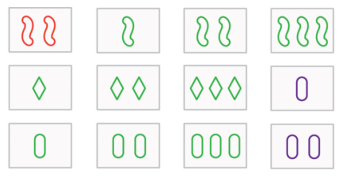

In [254]:
# PLOT SOLUTION: MOST SETS POSSIBLE IN 12 CARDS
fig, axs = plt.subplots(3,4, sharex=True, sharey=True, figsize=(6,3))
for i in range(3):
    for j in range(4):
        card = cardopt2[i+3*j]
        ix = card[0] + card[1]*3 + card[2]*9 + card[3]*27
        axs[i,j].imshow( imlist[ix] )
        axs[i,j].axis('off')

---
# Question 3
 
If you pick 12 cards at random (again, from a single deck of 81 cards), what’s the probability that they contain at least one set?

#### Solution:

Here we will use a Monte Carlo simulation. Essentially, we simply pick random sets of 12 cards, count the number of sets we find, and then repeat a large number of times.

In [ ]:
# Question 3:
# 

# do this using simulation!
np.random.seed(42)
N = 10000

setcounts = []

for trial in range(N):
    ix = np.random.permutation(81)[:12]  # indices of cards to use
    z = np.zeros((81,1))
    z[ix,0] = 1
    setcounts.append(sum( A @ z == 3)[0] )

Probability of having at least one set = 96.74% ± 0.35%


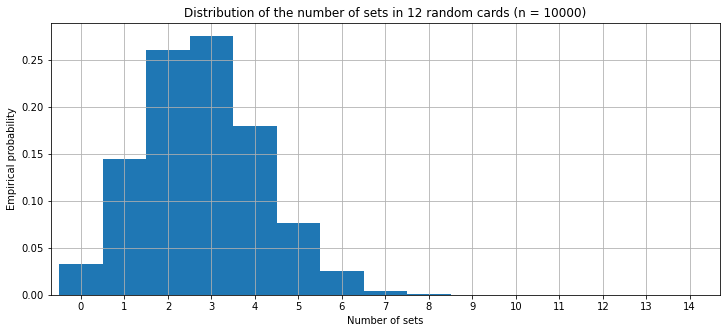

In [249]:
# make a histogram
plt.figure(figsize=(12,5))
vals = plt.hist(setcounts, bins=np.arange(-.5,15.5,step=1), density=True)

plt.grid()
plt.title("Distribution of the number of sets in 12 random cards (N = %g)" % N)
plt.xlabel("Number of sets")
plt.ylabel("Empirical probability")
plt.xlim([-.7,14.7])
plt.xticks(np.arange(0,15))

# compute 95% confidence interval
phat = 1 - vals[0][0]
conf95 = 1.96*np.sqrt(phat*(1-phat)/N)
print('Probability of having at least one set = %g%% ± %g%%' % ( round(100*phat,4),round(100*conf95,2) ))